## Learning Outcomes
1. K-means clustering
2. Anisotropic segmentation
3. Watershed segmentation

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from util_func import *

if not cv.useOptimized():
    cv.setUseOptimized(True)
    
cv.useOptimized()

True

## K-means clustering

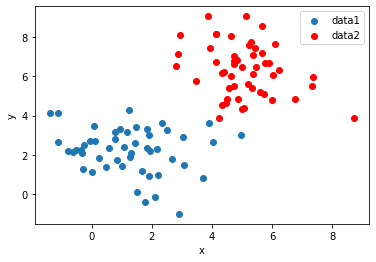

In [5]:
# generate  / sample data points from Gaussian probability distribution
# parameters are mean and covariance (2*2 matrix)

mean1 = (1,2)
cov1 = np.array([[2,0],[0,1]])
dat1 = np.random.multivariate_normal(mean1,cov1,size=50)

mean2 = (5,6)
cov2 = np.array([[1,0],[0,2]])
dat2 = np.random.multivariate_normal(mean2,cov2,size=50)

# combine into a dataset
data = np.concatenate((dat1,dat2),axis = 0)
Z = np.float32(data)

plt.scatter(dat1[:,0],dat1[:,1],label="data1")
plt.scatter(dat2[:,0],dat2[:,1],c="r",label = "data2")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

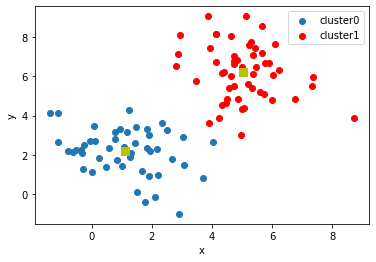

In [9]:
# apply k-means clustering
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER,10,1.0)
ret,label,center = cv.kmeans(Z,2,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
#ret is WCSOS

# subset the cluster
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:,0],A[:,1],label="cluster0")
plt.scatter(B[:,0],B[:,1],c="r",label = "cluster1")
plt.scatter(center[:,0],center[:,1],c="y",s=80,marker="s")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

## how to apply k-means clustering on image
reshape

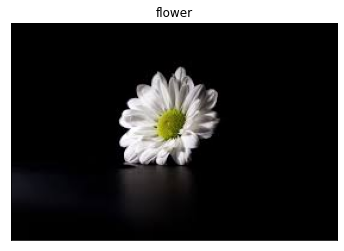

In [10]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt_img(img_rgb,"flower")

In [5]:
def k_means_clust(img,K,max_iter=10,eps=1.0,attempts=10,flag=cv.KMEANS_PP_CENTERS):
    """Args:
    img : 3channel image array
    K: number of clusters
    By default, max_iters =10,eps=1,attempts=10,k_means++"""
    #casting and reshape
    img = img.reshape((-1,3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER,max_iter,eps)
    return cv.kmeans(img,K,None,criteria,attempts,flag)

#ret,label,center = k_means_clust(img_rgb,3)

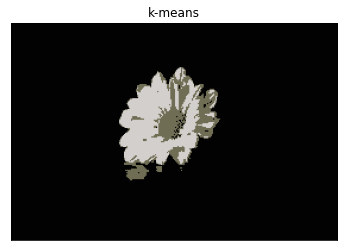

In [14]:
# visualize
# cast to uint8
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant,"k-means")

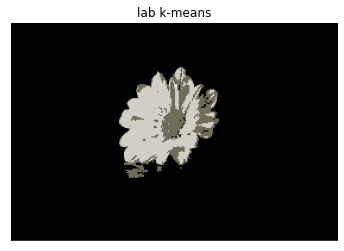

In [16]:
# LAB color space has the property of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret,label,center = k_means_clust(img_lab,3)

center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

quant_rgb = cv.cvtColor(quant,cv.COLOR_Lab2RGB)

plt_img(quant_rgb,"lab k-means")

In [17]:
np.unique(res,axis=0,return_counts=True)

(array([[  1, 128, 127],
        [115, 126, 139],
        [211, 128, 131]], dtype=uint8),
 array([45468,  1769,  3088], dtype=int64))

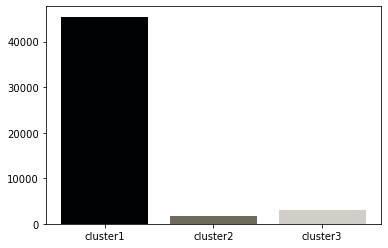

In [20]:
# make bar plot for all the cluster
# change lab to rgb
centroids, counts = np.unique(res,axis=0,return_counts=True)
res_rgb = centroids.reshape((3,1,3))
res_rgb = cv.cvtColor(res_rgb,cv.COLOR_Lab2RGB)
res_rgb = res_rgb.reshape((3,3))

# retrieve the counts
xlabel_name = ['cluster' + str(i) for i in range(1,4)]
plt.bar(xlabel_name,counts,color = list(res_rgb/255))
plt.show()

In [23]:
def calcGST(inputIMG, w,method_edge="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
        
    elif method_edge == "sobel":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    
    else:
        raise Exception("no edge detection method availaL")
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut


The problem of applying Gaussian filter instead of `cv.boxFilter` line 17 to line 19 is numerical stability (division by zero). The way to remedy this issue is by adding the denominator by a small constant (line 35).

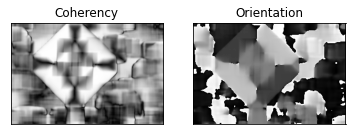

In [24]:
# display and conherency and orientation map
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img,(5,5),0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray,W)

# normalize
imgCoherency_norm = cv.normalize(imgCoherency, None, alpha = 0,beta =1, norm_type = cv.NORM_MINMAX,dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha = 0,beta =1, norm_type = cv.NORM_MINMAX,dtype=cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm,"Coherency")
plt.subplot(122), plt_img(imgOrientation_norm,"Orientation")
plt.show()

In [32]:
# trackbar function
def nothing(x):
    pass

wn = "anisotropic segmentation"
cv.namedWindow(wn,cv.WINDOW_NORMAL + cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency Threshold 1",wn,50,100,nothing)
cv.createTrackbar("Coherency Threshold 2",wn,70,100,nothing)

cv.createTrackbar("Orientation Threshold 1",wn,50,180,nothing)
cv.createTrackbar("Orientation Threshold 2",wn,100,180,nothing)

while True:
    # get trackbar positions
    th_C_1 = cv.getTrackbarPos("Coherency Threshold 1",wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency Threshold 2",wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation Threshold 1",wn)
    th_Or_2 = cv.getTrackbarPos("Orientation Threshold 2",wn)
    
    # thresholding
    imgBin_C_1 = cv.threshold(imgCoherency,th_C_1,255,cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency,th_C_2,255,cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation,th_Or_1,255,cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation,th_Or_2,255,cv.THRESH_BINARY_INV)[1]
        
    imgBin_C = cv.bitwise_and(imgBin_C_1,imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1,imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_C,imgBin_Or)
    
    mask = imgBin != 0
    res = img*(mask[:,:,None].astype(np.uint8))
    cv.imshow(wn,res)
    cv.imshow("segmentation mask",imgBin)

    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

## Watershed 
Topographic surface: edge map
marker : morphological gradient + threshold

In [33]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [49]:
# load image
img = cv.imread("images/traffic_sign.jfif") 
blur = cv.GaussianBlur(img,(5,5),0)
blur = cv.pyrMeanShiftFiltering(blur,15,29,maxLevel=2)

show_img("blur",blur)

In [50]:
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

#morphological graient
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11))
loc_grad = cv.morphologyEx(gray,cv.MORPH_GRADIENT,kernel,iterations = 2)

show_img("gradient",loc_grad)

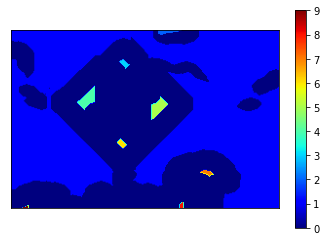

In [51]:
th  = loc_grad < 80
#connect componenet labeling
s = np.ones((3,3),dtype=int)
marker = ndi.label(th,structure=s)[0]

plt.imshow(marker, cmap = plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [52]:
edge = cv.Canny(gray, 250,500)
labels = watershed(edge, marker)
np.unique(labels,return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40255,   302,  1228,  2338,  2300,  1235,  1123,   748,   796],
       dtype=int64))

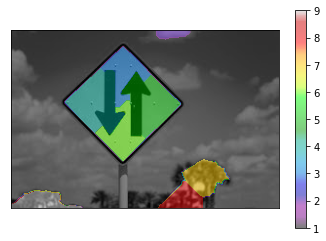

In [53]:
gray_ori = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori,cmap=plt.cm.gray)
plt.imshow(labels,cmap=plt.cm.nipy_spectral,alpha=0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [54]:
# create mask/binary image and set background to zero.
# assumption: background is always the majority
mask = 255 * np.ones(labels.shape, dtype=np.uint8)

label_vec, counts = np.unique(labels,return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

#contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#grab the largest contour
contour = sorted(contours, key= cv.contourArea,reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy,[contour],-1,(0,255,0),2)

show_img("contour", img_copy)

In [55]:
# bounding box
img_copy = img.copy()
x,y,w,h = cv.boundingRect(contour)
cv.rectangle(img_copy,(x,y),(x+w,y+h),(0,255,0),2)

show_img("bounding box",img_copy)

## Example 4

In [56]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [57]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [58]:
img_lab[..., 0].min()

6.0

In [59]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

In [60]:
from skimage.feature import peak_local_max

In [61]:
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)

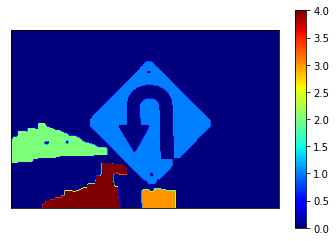

In [62]:
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

# Weekly Activity

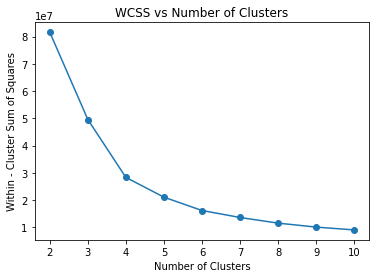

In [6]:
# Load Image
zebra = cv.imread("images/zebra.jfif")
zebra = cv.cvtColor(zebra, cv.COLOR_BGR2RGB)

# Reshape the image into 2D array
reshape = zebra.reshape(-1, 3)

# Determine the optimal k
wcss = []

for k in range(2, 11):
    ret, label, center = k_means_clust(zebra, k)
    wcss.append(ret)
    
plt.plot(range(2, 11), wcss, marker = "o")
plt.title("WCSS vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Within - Cluster Sum of Squares")
plt.show()

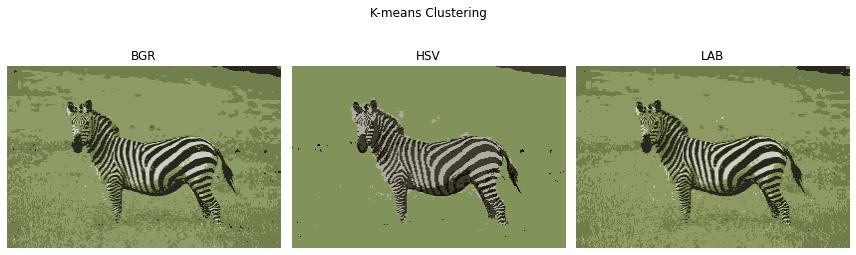

In [7]:
#Choose the optimal k based on the "elbow point" which is 4
optimal_k = 4

zebra_hsv = cv.cvtColor(zebra, cv.COLOR_BGR2HSV)
zebra_lab = cv.cvtColor(zebra, cv.COLOR_BGR2LAB)

#BGR
ret, label, center = k_means_clust(zebra, optimal_k)

center = np.uint8(center)
res = center[label.flatten()]
quant_BGR = res.reshape(zebra.shape)

#HSV
ret, label, center = k_means_clust(zebra_hsv, optimal_k)

center = np.uint8(center)
res = center[label.flatten()]
quant_hsv = res.reshape(zebra_hsv.shape)
quant_HSV = cv.cvtColor(quant_hsv, cv.COLOR_HSV2RGB)

#LAB
ret, label, center = k_means_clust(zebra_lab, optimal_k)

center = np.uint8(center)
res = center[label.flatten()]
quant_lab = res.reshape(zebra_lab.shape)
quant_LAB = cv.cvtColor(quant_lab, cv.COLOR_LAB2RGB)


plt.figure(figsize=(12, 4))
plt.suptitle("K-means Clustering")

# For BGR : It segmentation is not that good because the noise in the background is still segmented together with the zebra.
plt.subplot(1, 3, 1)
plt_img(quant_BGR)
plt.title("BGR")
plt.axis("off")

# For HSV : Compare to RGB  and LAB,it is the most effective segmentation although there is still some blobs behind the background.
plt.subplot(1, 3, 2)
plt_img(cv.cvtColor(quant_HSV, cv.COLOR_RGB2BGR))
plt.title("HSV")
plt.axis("off")

# For LAB : Same with RGB. Its segmentation is not that good because the noise in the background is still segmented together with the zebra.
plt.subplot(1, 3, 3)
plt_img(cv.cvtColor(quant_LAB, cv.COLOR_RGB2BGR))
plt.title("LAB")
plt.axis("off")

plt.tight_layout()
plt.show()
